In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
from FRVRS import nu

In [3]:

from FRVRS import fu
import os.path as osp

In [4]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 114)


In [5]:

columns_list = ['scene_type', 'is_scene_aborted', 'is_a_one_triage_file']
frvrs_logs_df[columns_list].drop_duplicates().sort_values(columns_list)

,scene_type,is_scene_aborted,is_a_one_triage_file
131522,Orientation,False,False
0,Orientation,False,True
71303,Triage,False,False
228,Triage,False,True



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


### R-squared

I am using the R-squared value of a linear regression model fit as a measure of how well responders engaged the still first, then wavers, then walkers last. A score of 1.0 will mean that the responder performed the ideal sequence. A score of -1.0 means that the responder performed the opposite sequence.

The algorithm will work for any number of patients. It allows for any number of still patients, which will be correctly placed in the beginning of the ideal sequence. The numbers are just the milliseconds of elapsed time at the engagement of a patient. The scenes are zero-indexed _SESSION_START_ to _SESSION_END_ segments. Time group 1 is the 2nd session in the file, for instance.

This is possibly also a measure of Tolerance for Risk (see https://nextcentury.atlassian.net/wiki/spaces/ITMC/pages/2998960129/KDMAs).

In [7]:

# Create a dataset of measures of right ordering
if nu.pickle_exists('engagement_sort_df'):
    engagement_sort_df = nu.load_object('engagement_sort_df')
else:
    
    # Group the data by session and scene
    groupby_columns = fu.scene_groupby_columns + ['logger_version', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file']
    gb = frvrs_logs_df.groupby(groupby_columns)
    
    # Iterate over each run to get the data rows
    rows_list = []
    for (session_uuid, scene_id, logger_version, is_scene_aborted, scene_type, is_a_one_triage_file), scene_df in gb:
        row_dict = {}
        
        # Populate the row dictionary with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
    
        # Set the last engagement time among all the obvious life threats
        assert ('tag_applied_type' in scene_df.columns)
        mask_series = scene_df.tag_applied_type.isin(['red', 'gray', 'black'])
        df = scene_df[mask_series]
        if df.shape[0]:
            patient_ids_list = df.patient_id.unique().tolist()
            mask_series = frvrs_logs_df.patient_id.isin(patient_ids_list)
            for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            row_dict['last_threat_engaged'] = fu.get_last_patient_interaction(frvrs_logs_df[mask_series])
        
        # Group the patients by their SORT category and get the last elapsed times
        sort_dict = {}
        for sort, patient_sort_df in scene_df.groupby('patient_sort'):
            if sort in fu.right_ordering_list:
                
                # Get the SORT's entire history
                patient_ids_list = patient_sort_df.patient_id.unique()
                mask_series = frvrs_logs_df.patient_id.isin(patient_ids_list)
                for cn in fu.scene_groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
                
                # Add the last engaged sort
                row_dict[f'last_{sort}_engaged'] = fu.get_last_patient_interaction(frvrs_logs_df[mask_series])
        
        # Get an R-squared Adjusted as a measure of right ordering
        row_dict['rsquared_adj'] = fu.get_measure_of_right_ordering(scene_df)
        
        rows_list.append(row_dict)
    
    engagement_sort_df = DataFrame(rows_list)
    nu.store_objects(engagement_sort_df=engagement_sort_df)

In [8]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
mask_series = engagement_sort_df.rsquared_adj.isnull()
df = engagement_sort_df[mask_series]
print(df.shape)
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

(136, 11)


,84,242,414,87
session_uuid,1df10bfd-0f85-42ff-a873-36dfe05df77b,5c2a444a-9c8d-4c65-bef2-c5f47f6b258d,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,1e7d274d-f393-4888-9f28-4de53b0260e3
scene_id,1,0,1,1
logger_version,1.3,1.0,1.3,1.0
is_scene_aborted,False,False,False,False
scene_type,Triage,Triage,Triage,Triage
is_a_one_triage_file,False,True,False,False
last_threat_engaged,124494.0,NaN,NaN,NaN
last_still_engaged,124494.0,53785.0,219308.0,NaN
last_walker_engaged,256861.0,43400.0,224285.0,479691.0
last_waver_engaged,181150.0,68077.0,219308.0,479691.0


In [8]:

columns_list = ['is_scene_aborted', 'is_a_one_triage_file']
nu.get_minority_combinations(engagement_sort_df, columns_list)

,session_uuid,scene_id,logger_version,is_scene_aborted,scene_type,is_a_one_triage_file,last_threat_engaged,last_still_engaged,last_walker_engaged,last_waver_engaged,rsquared_adj
415,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,2,1.3,False,Triage,False,813809.0,801090.0,781805.0,830217.0,-0.059906
4,02f6a42e-5211-40ea-8384-824a83ab6760,0,1.0,False,Triage,True,407473.0,407473.0,562962.0,630524.0,0.844740



Here is a histogram of the values:

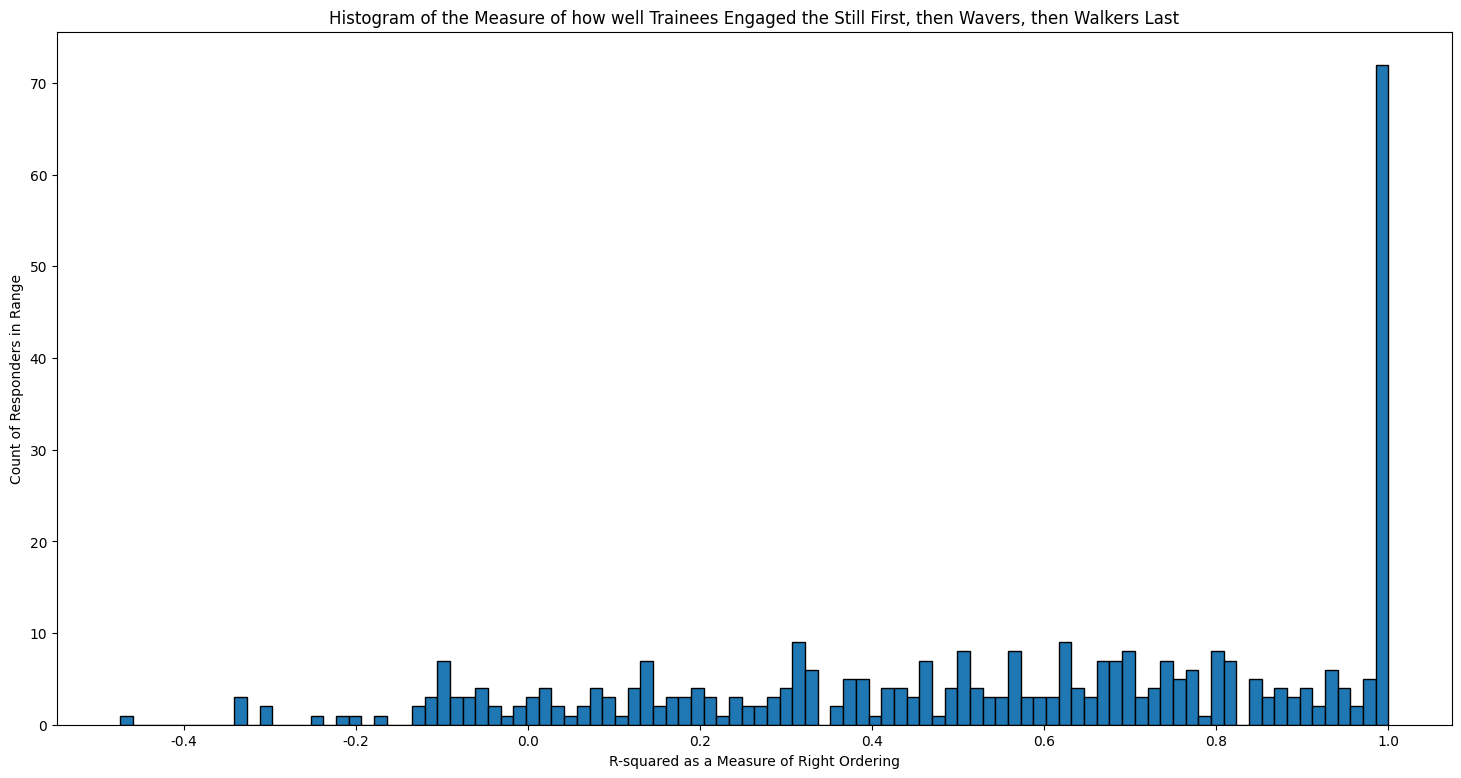

In [9]:

# Display a histogram of the distribution of the measure of
# how well responders engaged the still first, then wavers, then walkers last
xlabel = 'R-squared as a Measure of Right Ordering'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Measure of how well Trainees Engaged the Still First, then Wavers, then Walkers Last'
ylabel = 'Count of Responders in Range'
mask_series = (engagement_sort_df.scene_type == 'Triage') & (engagement_sort_df.is_scene_aborted == False) & (engagement_sort_df.is_a_one_triage_file == True)
ax = nu.plot_histogram(engagement_sort_df[mask_series], 'rsquared_adj', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False)

In [10]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (engagement_sort_df.scene_type == 'Triage') & (engagement_sort_df.is_scene_aborted == False) & (engagement_sort_df.is_a_one_triage_file == True)
columns_list = [
    'rsquared_adj'
]
df = engagement_sort_df[mask_series][columns_list]
display(fu.get_statistics(df, columns_list).applymap(lambda x: round(x, 1), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
rsquared_adj,0.6,1.0,0.6,0.4,-0.5,0.3,0.6,0.9,1.0


In [11]:

mask_series = (engagement_sort_df.scene_type == 'Triage') & (engagement_sort_df.is_scene_aborted == False) & (engagement_sort_df.is_a_one_triage_file == True)
df = engagement_sort_df[mask_series]
srs = df.value_counts(subset=['rsquared_adj'])
display(srs)
print(100*srs.iloc[0]/srs.size)

rsquared_adj
1.000000        63
0.674873         1
0.687743         1
0.686416         1
0.682185         1
                ..
0.312529         1
0.312119         1
0.311334         1
0.311082         1
0.512724         1
Name: count, Length: 311, dtype: int64

20.257234726688104


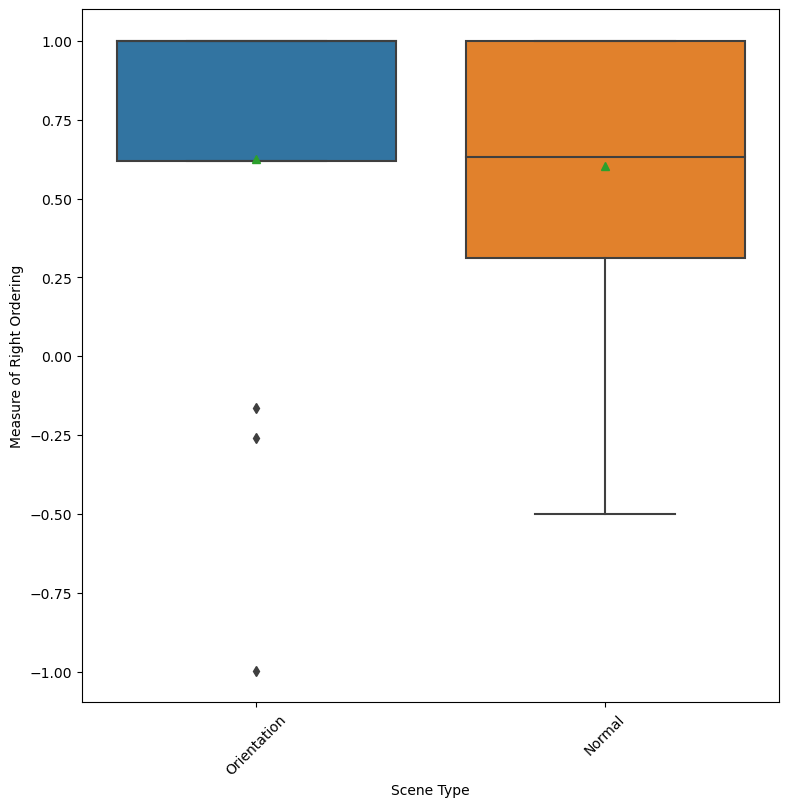

In [8]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (engagement_sort_df.is_scene_aborted == False)
df = engagement_sort_df[mask_series]
fu.plot_grouped_box_and_whiskers(df, 'scene_type', 'rsquared_adj', 'Scene Type', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)

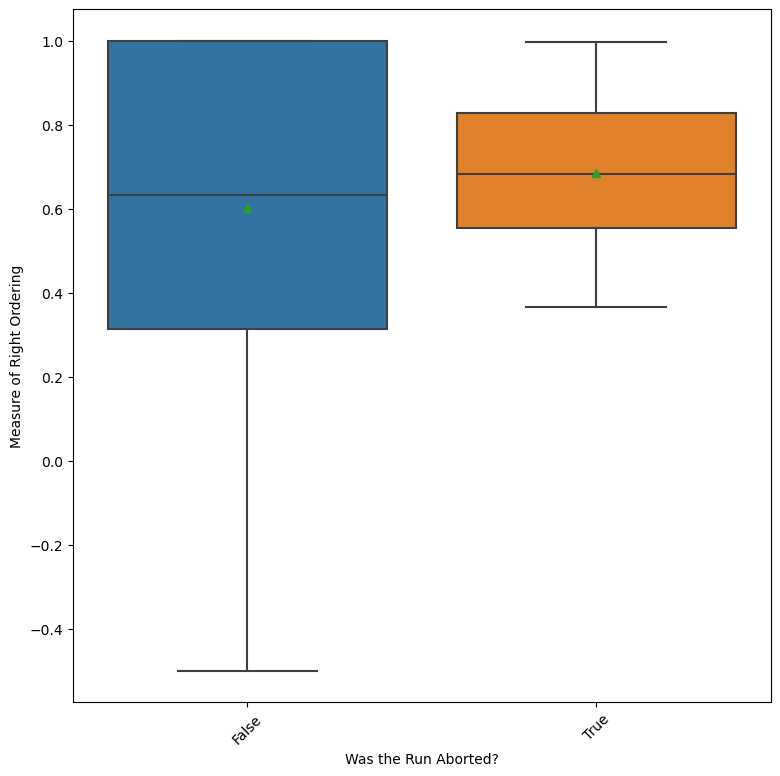

In [9]:

mask_series = (engagement_sort_df.scene_type == 'Triage')
df = engagement_sort_df[mask_series]
fu.plot_grouped_box_and_whiskers(df, 'is_scene_aborted', 'rsquared_adj', 'Was the Run Aborted?', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)


## How many responders did the right order? Should be a percentage of all responders


In [10]:

mask_series = (engagement_sort_df.scene_type == 'Triage') & (engagement_sort_df.is_scene_aborted == False)
total_count = engagement_sort_df[mask_series].shape[0]
mask_series &= (engagement_sort_df.rsquared_adj == 1.0)
correct_count = engagement_sort_df[mask_series].shape[0]
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of non-orientation, not-scene-aborted responders engaged the still first, then wavers, then walkers last, in an ideal sequence.')

19.28% of non-orientation, not-scene-aborted responders engaged the still first, then wavers, then walkers last, in an ideal sequence.
